<a href="https://colab.research.google.com/github/JTStephens18/MVDreamTest/blob/main/MVDream_NeRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/bytedance/MVDream

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from mvdream.model_zoo import build_model
from mvdream.camera_utils import get_camera
from mvdream.ldm.models.diffusion.ddim import DDIMSampler

In [ ]:
model = build_model("sd-v2.1-base-4view")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def t2i(model, img_size, prompt, uc, sampler, step=20, scale=7.5, batch_size=4,
        ddim_eta=0., dtype=torch.float32, device="cuda", camera=None, num_frames=1):
  if type(prompt) != list:
    prompt = [prompt]
  with torch.no_grad():
    c = model.get_learned_conditioning(prompt).to(device)
    c_ = {"context": c.repeat(batch_size, 1, 1)}
    uc_ = {"context": uc.repeat(batch_size, 1, 1)}
    if camera is not None:
      c_["camera"] = uc_["camera"] = camera
      c_["num_frames"] = uc_["num_frames"] = num_frames

    shape = [4, img_size // 8, img_size // 8]
    samples_ddim, _ = sampler.sample(S=step, conditioning=c_,
                                        batch_size=batch_size, shape=shape,
                                        verbose=False,
                                        unconditional_guidance_scale=scale,
                                        unconditional_conditioning=uc_,
                                        eta=ddim_eta, x_T=None)
    x_sample = model.decode_first_stage(samples_ddim)
    x_sample = torch.clamp((x_sample + 1.0) / 2.0, min=0.0, max=1.0)
    x_sample = 255. * x_sample.permute(0,2,3,1).cpu().numpy()

  return list(x_sample.astype(np.uint8))

In [ ]:
def create_camera_to_world_matrix(elevation, azimuth):
    elevation = np.radians(elevation)
    azimuth = np.radians(azimuth)
    # Convert elevation and azimuth angles to Cartesian coordinates on a unit sphere
    x = np.cos(elevation) * np.sin(azimuth)
    y = np.sin(elevation)
    z = np.cos(elevation) * np.cos(azimuth)

    # Calculate camera position, target, and up vectors
    camera_pos = np.array([x, y, z])
    target = np.array([0, 0, 0])
    up = np.array([0, 1, 0])

    # Construct view matrix
    forward = target - camera_pos
    forward /= np.linalg.norm(forward)
    right = np.cross(forward, up)
    right /= np.linalg.norm(right)
    new_up = np.cross(right, forward)
    new_up /= np.linalg.norm(new_up)
    cam2world = np.eye(4)
    cam2world[:3, :3] = np.array([right, new_up, -forward]).T
    cam2world[:3, 3] = camera_pos
    return cam2world


def convert_opengl_to_blender(camera_matrix):
    if isinstance(camera_matrix, np.ndarray):
        # Construct transformation matrix to convert from OpenGL space to Blender space
        flip_yz = np.array([[1, 0, 0, 0], [0, 0, -1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])
        camera_matrix_blender = np.dot(flip_yz, camera_matrix)
    else:
        # Construct transformation matrix to convert from OpenGL space to Blender space
        flip_yz = torch.tensor([[1, 0, 0, 0], [0, 0, -1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])
        if camera_matrix.ndim == 3:
            flip_yz = flip_yz.unsqueeze(0)
        camera_matrix_blender = torch.matmul(flip_yz.to(camera_matrix), camera_matrix)
    return camera_matrix_blender


def normalize_camera(camera_matrix):
    ''' normalize the camera location onto a unit-sphere'''
    if isinstance(camera_matrix, np.ndarray):
        camera_matrix = camera_matrix.reshape(-1,4,4)
        translation = camera_matrix[:,:3,3]
        translation = translation / (np.linalg.norm(translation, axis=1, keepdims=True) + 1e-8)
        camera_matrix[:,:3,3] = translation
    else:
        camera_matrix = camera_matrix.reshape(-1,4,4)
        translation = camera_matrix[:,:3,3]
        translation = translation / (torch.norm(translation, dim=1, keepdim=True) + 1e-8)
        camera_matrix[:,:3,3] = translation
    return camera_matrix.reshape(-1,16)


def get_camera(num_frames, elevation=15, azimuth_start=0, azimuth_span=360, blender_coord=True):
    angle_gap = azimuth_span / num_frames
    cameras = []
    for azimuth in np.arange(azimuth_start, azimuth_span+azimuth_start, angle_gap):
        camera_matrix = create_camera_to_world_matrix(elevation, azimuth)
        if blender_coord:
            camera_matrix = convert_opengl_to_blender(camera_matrix)
        cameras.append(camera_matrix.flatten())
    return torch.tensor(np.stack(cameras, 0)).float()

In [ ]:
camera = get_camera(4).to(device)
print("camera", camera[0])

In [ ]:
batch_size = 8
num_frames = 8

camera = get_camera(8).to(device)
print("camera", camera[0])
print(camera.shape)
model.device = device
model.to(device)
model.eval()
sampler = DDIMSampler(model)
uc = model.get_learned_conditioning( [""] ).to(device)

prompt = "an astronaut riding a horse"

images = []

for j in range(3):
  img = t2i(model, 256, prompt, uc, sampler, step=50, scale=10, batch_size=batch_size, ddim_eta=0.0,
            dtype=torch.float32, device=device, camera=camera, num_frames=num_frames)
  img = np.concatenate(img, 1)
  images.append(img)

In [ ]:
reshape = camera.reshape(4, 4, 4)
print(reshape)
r32 = reshape[:, 2, 1]
r33 = reshape[:, 2, 2]
print(r32)
print(r33)
# Phi
x_angle = torch.atan2(r32, r33)
print("x_angle", x_angle)

r31 = reshape[:, 2, 0]
print(r31)
sqrt = torch.sqrt(r32**2 + r33**2)
y_angle = torch.atan2(-r31, sqrt)
print("y_angle", y_angle)
r21 = reshape[:, 1, 0]
r11 = reshape[:, 0, 0]
# Theta
z_angle = torch.atan2(r21, r11)
print("z_angle", z_angle)

In [ ]:
torch.save(camera, "/content/drive/MyDrive/MVDiffusion/cameraTensor.pt")

In [ ]:
savedImg1 = Image.fromarray(images[0][:, :256, :])
savedImg2 = Image.fromarray(images[0][:, 256:512, :])
savedImg3 = Image.fromarray(images[0][:, 512:768, :])
savedImg4 = Image.fromarray(images[0][:, 768:1024, :])
savedImg5 = Image.fromarray(images[0][:, 1024:1280, :])
savedImg6 = Image.fromarray(images[0][:, 1280:1536, :])
savedImg7 = Image.fromarray(images[0][:, 1536:1792, :])
savedImg8 = Image.fromarray(images[0][:, 1792:, :])


image1 = Image.fromarray(np.uint8(savedImg1))
image2 = Image.fromarray(np.uint8(savedImg2))
image3 = Image.fromarray(np.uint8(savedImg3))
image4 = Image.fromarray(np.uint8(savedImg4))
image5 = Image.fromarray(np.uint8(savedImg5))
image6 = Image.fromarray(np.uint8(savedImg6))
image7 = Image.fromarray(np.uint8(savedImg7))
image8 = Image.fromarray(np.uint8(savedImg8))

image1.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse1.png")
image2.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse2.png")
image3.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse3.png")
image4.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse4.png")
image5.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse5.png")
image6.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse6.png")
image7.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse7.png")
image8.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse8.png")

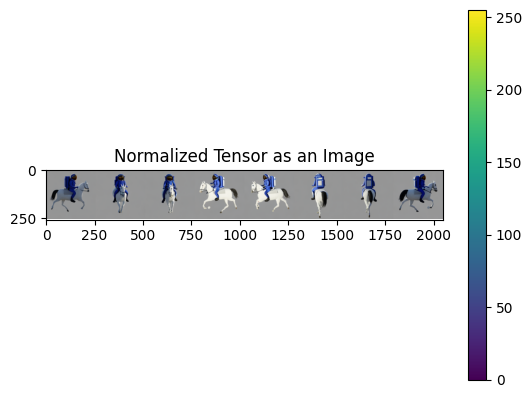

In [ ]:
plt.imshow(images[0])
plt.colorbar()
plt.title('Normalized Tensor as an Image')
plt.show()

Working with loaded images

Helpful resources:

https://dtransposed.github.io/blog/2022/08/06/NeRF/

https://github.com/krrish94/nerf-pytorch/blob/master/tiny_nerf.py

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import numpy as np
import math
from torchvision import transforms
from PIL import Image

In [ ]:
imageHolder = []
img1 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse1.png")
img2 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse2.png")
img3 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse3.png")
img4 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse4.png")
img5 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse5.png")
img6 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse6.png")
img7 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse7.png")
img8 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse8.png")

transform = transforms.ToTensor()

imageHolder.append(transform(img1))
imageHolder.append(transform(img2))
imageHolder.append(transform(img3))
imageHolder.append(transform(img4))
imageHolder.append(transform(img5))
imageHolder.append(transform(img6))
imageHolder.append(transform(img7))
imageHolder.append(transform(img8))


imageTensor = torch.stack(imageHolder)
print(imageTensor.shape)

torch.Size([8, 3, 256, 256])


In [ ]:
# im1 = img1.resize((64, 64))
# im2 = img2.resize((64, 64))
# im3 = img3.resize((64, 64))
# im4 = img4.resize((64, 64))
# im5 = img5.resize((64, 64))
# im6 = img6.resize((64, 64))
# im7 = img7.resize((64, 64))
# im8 = img8.resize((64, 64))

# im1.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse1_x64.png")
# im2.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse2_x64.png")
# im3.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse3_x64.png")
# im4.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse4_x64.png")
# im5.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse5_x64.png")
# im6.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse6_x64.png")
# im7.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse7_x64.png")
# im8.save("/content/drive/MyDrive/MVDiffusion/images/astroHorse8_x64.png")

imageHolder = []
img1 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse1_x64.png")
img2 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse2_x64.png")
img3 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse3_x64.png")
img4 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse4_x64.png")
img5 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse5_x64.png")
img6 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse6_x64.png")
img7 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse7_x64.png")
img8 = Image.open("/content/drive/MyDrive/MVDiffusion/images/astroHorse8_x64.png")

transform = transforms.ToTensor()

imageHolder.append(transform(img1))
imageHolder.append(transform(img2))
imageHolder.append(transform(img3))
imageHolder.append(transform(img4))
imageHolder.append(transform(img5))
imageHolder.append(transform(img6))
imageHolder.append(transform(img7))
imageHolder.append(transform(img8))


imageTensor = torch.stack(imageHolder)
print(imageTensor.shape)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
cameraTensor = torch.load("/content/drive/MyDrive/MVDiffusion/cameraTensor.pt", map_location=torch.device('cpu'))
print(cameraTensor.shape)

In [ ]:
camera = cameraTensor.reshape(-1, 4, 4)
print(camera.shape)

In [ ]:
def calculate_angles(camera):
  r32 = camera[:, 2, 1]
  r33 = camera[:, 2, 2]
  phi = torch.atan2(r32, r33)
  r21 = camera[:, 1, 0]
  r11 = camera[:, 0, 0]
  theta = torch.atan2(r21, r11)
  angles = torch.stack((phi, theta), dim=1)
  return angles

In [ ]:
angles = torch.zeros(8, 64, 64, 16, 2).to(device)
anglesVals = calculate_angles(camera).to(device)
for b in range(anglesVals.shape[0]):
  angles[b, :, :, :, 0] = anglesVals[b, 0]
  angles[b, :, :, :, 1] = anglesVals[b, 1]
print(angles.shape)

In [ ]:
def pixel_to_ndc_and_screen(tensor):
  b_size, num_c, height, width = tensor.shape

  # FOV
  alpha = 90
  fov = torch.tan(torch.tensor(math.radians(alpha / 2)))

  x = torch.arange(width)
  y = torch.arange(height)

  xx, yy = torch.meshgrid(x, y, indexing='ij')
  pixel_pos = torch.stack([xx, yy], axis=-1)

  ndc_pos = (pixel_pos + 0.5) / torch.tensor([width, height])

  screen_pos = (2 * ndc_pos - 1) * fov
  screen_pos[..., 1] = 1 - 2 * ndc_pos[..., 1] * fov

  return ndc_pos, screen_pos

In [ ]:
ndc_pos, screen_pos = pixel_to_ndc_and_screen(imageTensor)
print("ndc", ndc_pos.shape)
print(torch.max(ndc_pos))
print(torch.min(ndc_pos))

print("screen", screen_pos.shape)
print(torch.max(screen_pos))
print(torch.min(screen_pos))

imageTensor = imageTensor.permute(0, 3, 2, 1).to(device)

In [ ]:
def normalize_vector(vector):
  magnitude = torch.linalg.norm(vector, axis=-1, keepdim=True)
  return vector / magnitude

In [ ]:
def apply_camera_to_world_matrix(matrix, camera_origin, points):
  b_size = matrix.shape[0]
# Convert origin and screen points to homogeneous coordinates
  camera_origin_homogeneous = torch.cat((camera_origin, torch.ones(1)))
  ones_tensor = torch.ones(points.shape[0], points.shape[1], 1)
  point_homogeneous = torch.cat((points, ones_tensor), dim=2)
# Create temporary tensors to store calculated values - done this way mainly to account for camera batch size
  point_homogeneous_tensor = torch.zeros(b_size, point_homogeneous.shape[0], point_homogeneous.shape[1], point_homogeneous.shape[2])
  point_homogeneous_tensor[:] = point_homogeneous

  transformed_point = torch.zeros(b_size, points.shape[0], points.shape[1], points.shape[2]+1)
  transformed_origin = torch.zeros(b_size, camera_origin_homogeneous.shape[0])
  origin_output = torch.zeros(b_size, camera_origin_homogeneous.shape[0]-1)
  point_output = torch.zeros(b_size,  points.shape[0], points.shape[1], points.shape[2])

  for b in range(b_size):
    # Apply camera to world matrix
    transformed_origin[b] = torch.mv(matrix[b], camera_origin_homogeneous)

    for i in range(points.shape[0]):
      for j in range(points.shape[1]):
        transformed_point[b,i,j] = torch.mv(matrix[b], point_homogeneous_tensor[b,i,j])

    # Convert back to 3-dimension coordinates using dehomogenization
    origin_output[b] = transformed_origin[b, :3] / transformed_origin[b, 3]
    point_output[b] = transformed_point[b, :, :, :3] / transformed_point[b, :, :, 3].unsqueeze(2)

  return origin_output, point_output

In [ ]:
# Update screen pos to have -1 in last dimension (z)
negative_z = torch.ones(screen_pos.shape[0], screen_pos.shape[1],1) * -1
new_screen_pos = torch.cat((screen_pos, negative_z), dim=2)
rayDirection = torch.zeros(8, 64, 64, 3)

# Camera's original point. It is at 0,0,0 until camera matrix is applied
rayOrigin = torch.tensor([0,0,0])
rayOriginWorld, rayPointWorld = apply_camera_to_world_matrix(camera, rayOrigin, new_screen_pos)
for b in range(camera.shape[0]):
  rayDirection[b] = rayPointWorld[b] - rayOriginWorld[b]

# Noramlized to have a length of 1. Keeps the direction, but not the magnitude
rayDirection = normalize_vector(rayDirection)

In [ ]:
def sample_points(origin, vector, num_samples=16):
  sampled_points = torch.zeros(vector.shape[0], vector.shape[1], vector.shape[2], num_samples, 3)
  t = 1 / num_samples
  for s in range(num_samples):
    for b in range(vector.shape[0]):
      sampled_points[b, :, :, s, :] = origin[b] + ((t*s) * vector[b])

  return sampled_points

In [ ]:
sampled_points = sample_points(rayOriginWorld, rayDirection)

In [ ]:
def positional_encoding(points):
  tempArr = []
  p1 = torch.sin(math.pi*points)
  tempArr.append(p1)
  p2 = torch.cos(math.pi*points)
  tempArr.append(p2)
  p3 = torch.sin(2*math.pi*points)
  tempArr.append(p3)
  p4 = torch.cos(2*math.pi*points)
  tempArr.append(p4)

  final = torch.stack(tempArr, dim=4).reshape(points.shape[0], points.shape[1], points.shape[2], points.shape[3], -1)
  return final

In [ ]:
encoded = positional_encoding(sampled_points).to(device)

In [ ]:
class NERF(nn.Module):
  def __init__(self, in_c):
    super(NERF, self).__init__()

    self.fc1 = nn.Linear(in_c, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, 256)
    self.fc4 = nn.Linear(256, 256)
    self.fc5 = nn.Linear(256, 256)
    self.fc6 = nn.Linear(256, 256)
    self.fc7 = nn.Linear(256, 256)
    self.fc8 = nn.Linear(256, 256)

    self.final = nn.Linear(258, 128)
    self.color = nn.Linear(128, 3)
    self.density = nn.Linear(256, 1)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, points, cameraAngles):
    x = self.fc1(points)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.relu(x)

    density = self.density(x)
    # Concat
    x = torch.cat((cameraAngles, x), dim=-1)
    x = self.final(x)
    x = self.relu(x)
    x = self.color(x)
    x = self.sigmoid(x)

    return density, x

In [ ]:
model = NERF(12).to(device)

In [ ]:
print(model)

for name, param in model.named_parameters():
  if param.grad is not None:
    print(name, torch.norm(param.grad).item())

In [ ]:
e = torch.randn(8, 64, 64, 16, 12)
c = torch.randn(8, 64, 64, 16, 2)

o = torch.cat((e, c), dim=-1)
print(o.shape)

torch.Size([8, 64, 64, 16, 14])


In [ ]:
density, color = model(encoded, angles)

In [ ]:
def cumprod_exclusive(tensor):
    dim = -1
    cumprod = torch.cumprod(tensor, dim)
    cumprod = torch.roll(cumprod, 1, dim)
    cumprod[..., 0] = 1.0
    return cumprod

In [ ]:
dists = 0.0625
sigma_a = torch.randn(8, 64, 64, 16, 1)
alpha = 1.0 - torch.exp(-sigma_a * dists)
weights = alpha * cumprod_exclusive(1.0 - alpha + 1e-10)

In [ ]:
rgb = torch.randn(8, 64, 64, 16, 3)
pred_rgb = (weights[...] * rgb).sum(dim=3)

In [ ]:
print(pred_rgb.shape)
print(weights[...].shape)

In [ ]:
img = imageTensor[0]
print(img.shape)

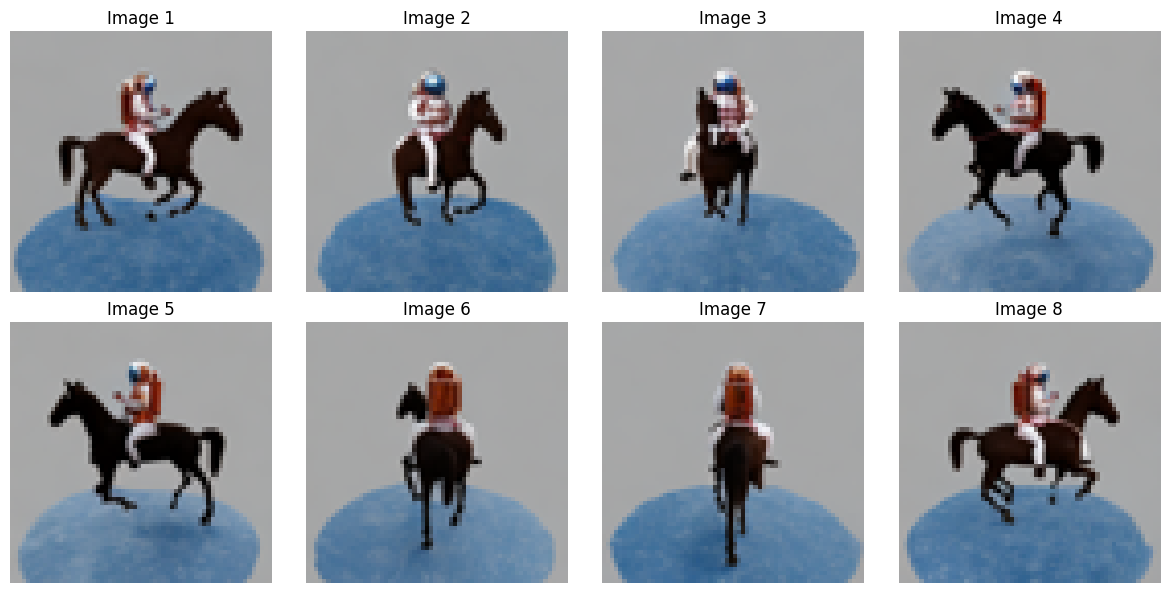

In [ ]:
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(8):
        ax = axes[i//4, i%4]
        item = imageTensor[i].detach().cpu().numpy()
        image = np.transpose(item, (1,0,2))
        ax.imshow(image)
        ax.set_title(f'Image {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Optimizer
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

In [ ]:
# Pass in precalculated encoded positions and camera angles to model
# Model outputs density and RGB
# Use density and RGB to create an image
# Calculate loss based on created image and real image
# Backpropagate

epochs = 100000
dists = 0.0625
for epoch in range(epochs):
   print("Epoch", epoch)
   density, rgb = model(encoded, angles)
   alpha = 1.0 - torch.exp(-density * dists)
   weights = alpha * cumprod_exclusive(1.0 - alpha + 1e-10)

   pred_rgb = (weights * rgb).sum(dim=-2)

   mseLoss = nn.MSELoss()

   loss = mseLoss(pred_rgb, imageTensor)
   print("Loss:", loss.item())
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()

   if epoch % 1000 == 0:
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(8):
        ax = axes[i//4, i%4]
        item = pred_rgb[i].detach().cpu().numpy()
        image = np.transpose(item, (1,0,2))
        ax.imshow(image)
        ax.set_title(f'Image {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
checkpoint = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}

torch.save(checkpoint, 'NERFCheckpoint.pth')
! cp NERFCheckpoint.pth /content/drive/MyDrive/MVDiffusion/NERFCheckpoint.pth

In [ ]:
def plotImages(img1, img2):
  index = 7
  fig, axes = plt.subplots(1, 2)

  image1 = np.transpose(img1[index], (1,0,2))
  axes[0].imshow(image1)
  axes[0].set_title("NeRF Image")

  image2 = np.transpose(img2[index], (1,0,2))
  axes[1].imshow(image2)
  axes[1].set_title("Ground Truth")

  plt.tight_layout()
  plt.show()

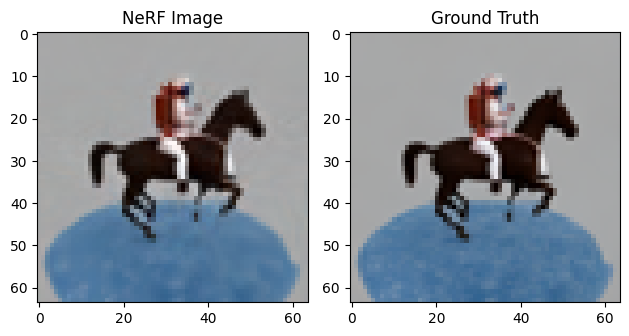

In [ ]:
plotImages(pred_rgb.detach().cpu().numpy(), imageTensor.cpu().numpy())

## Some helper functions

In [ ]:
def plot_vector_direction(origin, *vectors):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for vector in vectors:
      # Extract components of the vector
      x, y, z = vector

      # Plot the vector
      ax.quiver(origin[0], origin[1], origin[2], x, y, z, color='b', arrow_length_ratio=0.1)

    # Set limits
    max_val = max(max(abs(x), abs(y)), abs(z))
    ax.set_xlim([-max_val, max_val])
    ax.set_ylim([-max_val, max_val])
    ax.set_zlim([-max_val, max_val])

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

In [ ]:
batches = [0,1,2,3,4,5,6,7]
direction_arr = []
origin_arr = []
for i in range(len(batches)):
  origin_arr.append(rayOriginWorld[i])
  direction_arr.append(rayDirection[i, 0,0])
  direction_arr.append(rayDirection[i, 255, 0])
  direction_arr.append(rayDirection[i, 0, 255])
  direction_arr.append(rayDirection[i, 255, 255])


In [ ]:
print(torch.min(rayDirection))

tensor(-1.0000)


In [ ]:
import plotly.graph_objects as go

def plotly_vector_direction(origins, vectors):
    i = -1
    fig = go.Figure()
    colors = ['blue', 'red', 'green', 'orange', 'purple', "brown", 'pink', 'black']
    for origin in origins:
      i = i+1
      color = colors[i % len(colors)]
      for vector in vectors[i:i+4]:
          # Extract components of the vector
          # x, y, z = vector
          x,y,z = origin

          # Plot the vector
          fig.add_trace(go.Scatter3d(
              x=[x],
              y=[y],
              z=[z],
              mode='lines+markers',
              line=dict(color=color, width=3),
              marker=dict(color=color, size=5),
          ))

    # Set axes title
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        xaxis_range=[-2, 2],
        yaxis_range=[-2, 2],
        zaxis_range=[-2, 2]
    ))

    fig.show()

# Example usage
batch = 3
plotly_vector_direction(origin_arr, direction_arr)
# plot_vector_direction(rayOriginWorld[batch], rayDirection[batch,0,0], rayDirection[batch,0,255], rayDirection[batch,255,0], rayDirection[batch,255,255])

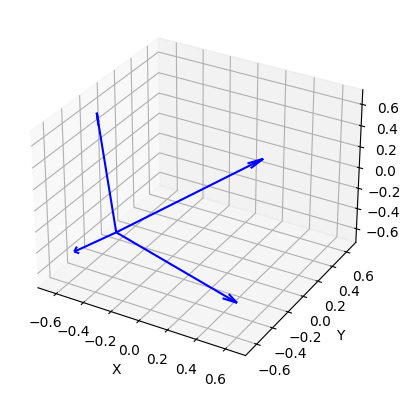

In [ ]:
batch = 0
plot_vector_direction(rayOriginWorld[batch], rayDirection[batch,0,0], rayDirection[batch,0,255], rayDirection[batch,255,0], rayDirection[batch,255,255])

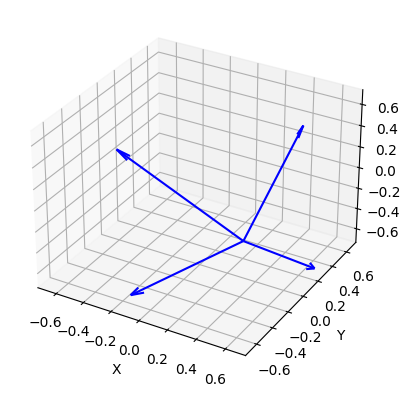

In [ ]:
batch = 1
plot_vector_direction(rayOriginWorld[batch], rayDirection[batch,0,0], rayDirection[batch,0,255], rayDirection[batch,255,0], rayDirection[batch,255,255])

In [ ]:
point = rayOriginWorld[1] + 0.2*rayDirection[1,0,0]
print(point)

tensor([ 0.5013, -0.6644,  0.3402])
